In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
rng = np.random.default_rng(12345)

inf_list = ['xs', 'ys', 'zs', 'alphas', 'hs', 'phis', 'r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']
number_samples = 2

xs = np.full((number_samples,1), 0.) if 'xs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
ys = np.full((number_samples,1), 0.) if 'ys' not in inf_list else rng.uniform(low=-2000, high=5000, size=(number_samples,1))
zs = np.full((number_samples,1), 50.) if 'zs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
alphas = np.full((number_samples,1), np.pi/4) if 'alphas' not in inf_list else rng.uniform(low=-(np.pi / 3), high=(np.pi / 3), size=(number_samples,1))
hs = np.full((number_samples,1), 1.) if 'hs' not in inf_list else rng.uniform(low=-1., high=1., size=(number_samples,1))
phis = np.full((number_samples,1), 0.) if 'phis' not in inf_list else rng.uniform(low=0, high=np.pi, size=(number_samples,1))
loc_param = np.concatenate((xs, ys, zs, alphas, hs, phis), axis=1)

r_s = np.full((number_samples,1), 8.0) if 'r_s' not in inf_list else rng.uniform(low=5, high=12, size=(number_samples,1))
l_t = np.full((number_samples,1), 600.0) if 'l_t' not in inf_list else rng.uniform(low=20., high=800., size=(number_samples,1))
r2_s = np.square(r_s)
clf = ClassifierBuilder()
clf.load_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")
gmax = clf.predict(np.column_stack((r2_s, l_t)))
r_t = np.full((number_samples,1), 1.25) if 'r_t' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r_d = np.full((number_samples,1), .28) if 'r_d' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r_tu = np.full((number_samples,1), .28) if 'r_tu' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
l_d = np.full((number_samples,1), 200.0) if 'l_d' not in inf_list else rng.normal(loc=((np.log(100) + np.log(300)) / 2), scale=((np.log(300) - np.log(100)) / 4), size=(number_samples,1))
geo_param = np.concatenate((r_s, l_t, r_t, r_d, r_tu, l_d), axis=1)

# geo_param = [8,600.,1.25,.28,.28,200.]
# geo_param = np.tile(geo_param, (number_samples, 1))

labels = np.concatenate((r_s, l_t), axis=1)#np.concatenate((loc_param, geo_param), axis=1)
np.set_printoptions(suppress=True)
print("Loc Parameters: {}".format(loc_param))
print("Geo Parameters: {}".format(geo_param))
print("Gmax: {}".format(gmax))
print(labels.shape)

Loc Parameters: [[ -27.26639775 3581.55820133  -10.88904494    0.20589737    0.34551209
     0.77988691]
 [ -18.32416603 2733.78269526  -16.71860721   -0.65610239    0.88360573
     2.98099806]]
Geo Parameters: [[  9.67066217 364.63493961  -0.48731996  -0.57301723  -0.2726798
    5.4024659 ]
 [  5.67128555 711.45433708  -1.31035129  -0.2418265   -0.92530549
    4.70910365]]
Gmax: [[0.02664097]
 [0.01687359]]
(2, 2)


In [3]:
from typing import Union, Tuple, List
from matplotlib.figure import Figure
from matplotlib.axes import Axes

def plot_v(sim: Simulation, cell_idx: np.ndarray = np.array([0, 1]),
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    t = sim.t()
    v = sim.v('all')
    fig, axs = plt.subplots(nrows=cell_idx.size, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*cell_idx.size)
    for i,ax in enumerate(axs):
        ax.plot(t,v[i,:])
        ax.set_ylabel('Vm (mV)')
#         ax.legend(loc=1)
    axs[0].set_title('Membrane Voltage vs Time')
    axs[-1].set_xlabel('Time (ms)')
    plt.show()
    return fig, axs 


def valid_count(sim):
    # number of valid spiking cells
    nspk = sim.get_spike_number('all')
    print(nspk)
    nvalid = np.count_nonzero(nspk == 1)
    return nvalid

[2 2]
Number of valid sample: 0


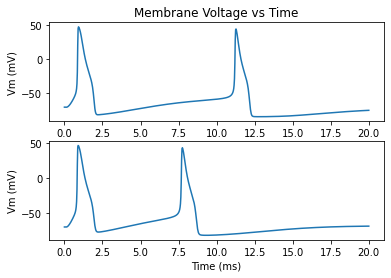

In [4]:
hf = h5py.File(paths.INVIVO_DATA_FILE, 'r')
groundtruth_lfp = np.array(hf.get('data'))
hf.close()

sim = Simulation(geometry = geo_standard, 
                 electrodes = params.ELECTRODE_POSITION, 
                 cell_type = CellTypes.ACTIVE, 
                 loc_param = loc_param, 
                 geo_param = geo_param,
                 spike_threshold = -20, 
                 gmax = gmax, 
                 scale = 1., 
                 ncell = number_samples)
# sim = Simulation(geo_standard,params.ELECTRODE_POSITION,loc_param,geo_param=geo_param,gmax=.001,scale=1000, ncell=ncell)  # gmax 0.001 -0.012
sec_list = sim.cells[0].all

filt_b,filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                              params.FILTER_CRITICAL_FREQUENCY,
                              params.BANDFILTER_TYPE,
                              fs=params.FILTER_SAMPLING_RATE)

sim.run_neuron_sim()
print("Number of valid sample: %d" % (valid_count(sim)))
_ = plot_v(sim)

lfp = sim.get_lfp('all').T

filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0) 

(801,)
(801, 384, 2)
(801, 384, 2)
Using column at x = -8 um


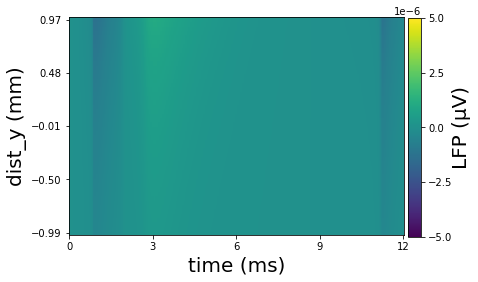

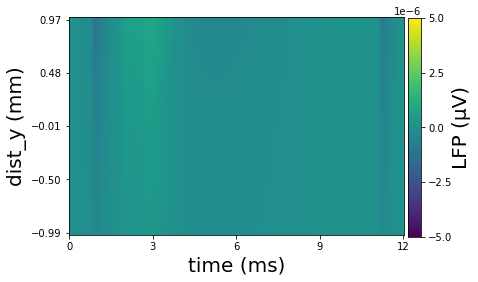

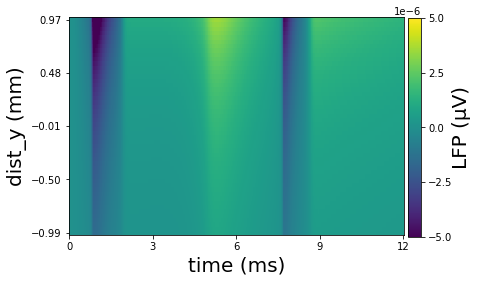

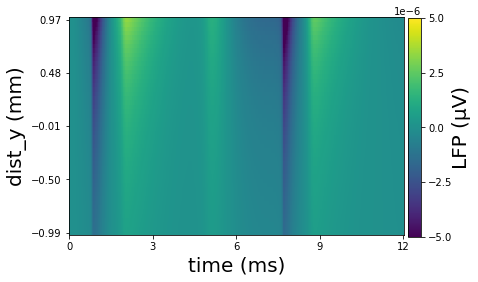

In [5]:
# vlim = 'auto'
vlim = [-0.000005,0.000005]
ylim = [-1000,1000]
window = [0,12]

t = sim.t()
print(t.shape)
print(lfp.shape)
print(filtered_lfp.shape)

idx = (t>=window[0]) & (t<=window[1])  # time index

x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
ix = 1
e_idx = ((params.ELECTRODE_POSITION[:,0]==x_dist[ix]) & 
         (params.ELECTRODE_POSITION[:,1]>=ylim[0]) & 
         (params.ELECTRODE_POSITION[:,1]<=ylim[1]))

print('Using column at x = %g um' % (x_dist[ix]))

for i in range(lfp.shape[2]):
    fig,ax = plot_lfp_heatmap(t[idx],params.ELECTRODE_POSITION[e_idx, 1],
                              (lfp[:,:,i])[idx][:, e_idx],vlim=vlim,
                              fontsize=20,labelpad=0,ticksize=10,nbins=5)

    fig,ax = plot_lfp_heatmap(t[idx],params.ELECTRODE_POSITION[e_idx, 1],
                              (filtered_lfp[:,:,i])[idx][:, e_idx],vlim=vlim,
                              fontsize=20,labelpad=0,ticksize=10,nbins=5)